In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

from opera_tropo.config import pge_runconfig
from opera_tropo.log.loggin_setup import setup_logging
from opera_tropo.utils import get_hres_datetime, get_max_memory_usage

In [3]:
from opera_tropo.run import tropo

In [4]:
cfg = pge_runconfig.RunConfig()
cfg = cfg.from_yaml('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/tropo/src/opera_tropo/config/default/pge_runconfig.yaml')
cfg.model_dump()

{'input_file': {'input_file_path': 'input_data/D01010000010100001.zz.nc',
  'date_fmt': '%Y%m%d'},
 'output_options': {'date_fmt': '%Y%m%dT%H%M%S',
  'creation_time': datetime.datetime(2025, 3, 15, 22, 56, 16, 808285, tzinfo=datetime.timezone.utc),
  'output_heights': [],
  'compression_kwargs': {'compression_flag': True,
   'zlib': True,
   'complevel': 5,
   'shuffle': True},
  'product_version': '0.1'},
 'primary_executable': {'product_type': 'OPERA_TROPO'},
 'product_path_group': {'product_path': PosixPath('output/historical'),
  'scratch_path': PosixPath('golden_output'),
  'output_path': PosixPath('output/historical'),
  'product_version': '0.1'},
 'worker_settings': {'n_workers': 4,
  'threads_per_worker': 2,
  'max_memory': 8,
  'dask_temp_dir': 'tmp',
  'block_shape': (128, 128)},
 'log_file': PosixPath('golden_output/log_sas.log')}

In [5]:
cfg.input_file.input_file_path = '/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/ECMWF_TROP_202402151200_202402151200_1.nc'
cfg.log_file = '/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/log_sas.log'
cfg.worker_settings.block_shape = (128, 128)

In [6]:
cfg.model_dump()

{'input_file': {'input_file_path': '/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/ECMWF_TROP_202402151200_202402151200_1.nc',
  'date_fmt': '%Y%m%d'},
 'output_options': {'date_fmt': '%Y%m%dT%H%M%S',
  'creation_time': datetime.datetime(2025, 3, 15, 22, 56, 16, 808285, tzinfo=datetime.timezone.utc),
  'output_heights': [],
  'compression_kwargs': {'compression_flag': True,
   'zlib': True,
   'complevel': 5,
   'shuffle': True},
  'product_version': '0.1'},
 'primary_executable': {'product_type': 'OPERA_TROPO'},
 'product_path_group': {'product_path': PosixPath('output/historical'),
  'scratch_path': PosixPath('golden_output'),
  'output_path': PosixPath('output/historical'),
  'product_version': '0.1'},
 'worker_settings': {'n_workers': 4,
  'threads_per_worker': 2,
  'max_memory': 8,
  'dask_temp_dir': 'tmp',
  'block_shape': (128, 128)},
 'log_file': '/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/log_sas.log'}

In [7]:
setup_logging(logger_name="opera_tropo", debug=False, filename=cfg.log_file)
setup_logging(logger_name="RAiDER", filename=cfg.log_file)  # not sure if this works, does not pick logging from RAIDER

In [8]:
workflow_cfg = cfg.to_workflow()
workflow_cfg.work_directory = Path('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data')
print(workflow_cfg.work_directory),
(workflow_cfg.work_directory).mkdir(exist_ok=True, parents=True)

# Remove RAIDER empty log files
(workflow_cfg.work_directory / 'debug.log').unlink(missing_ok=True)
(workflow_cfg.work_directory / 'log.log').unlink(missing_ok=True)

/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data


In [9]:
hres_date, hres_hour = get_hres_datetime(workflow_cfg.input_options.input_file_path)
output_filename = workflow_cfg.output_options.get_output_filename(hres_date, hres_hour)
output_filename

'OPERA_L4_TROPO_Z_20240215T120000Z_20250315T225616Z_HRES_v0.1.nc'

In [ ]:
workflow_cfg.worker_settings.block_shape[0]*4

# 128,128 = 874.34s, 42gb
# 128, 256 = 906.6s, 45GB
# 256, 128 = 896s, 48gb
# 256, 256 = 938s, 45gb
# 256, 512 = 995s, 45gb
# 512, 256 = 
# 512, 512 = 1162s, 45gb

512

In [9]:
workflow_cfg.worker_settings.dask_temp_dir

'golden_output/tmp'

In [10]:
tropo(file_path = workflow_cfg.input_options.input_file_path,
      output_file = Path(workflow_cfg.work_directory) / output_filename,
      out_heights = workflow_cfg.output_options.output_heights,
      block_size=[128, 256],
      subset=[slice(None, 500), slice(None, 500)],
      max_memory='16GB',
      num_workers = workflow_cfg.worker_settings.n_workers,
      num_threads = workflow_cfg.worker_settings.threads_per_worker,
      compression_options = workflow_cfg.output_options.compression_kwargs,
      temp_dir = workflow_cfg.worker_settings.dask_temp_dir,
      pre_check=False
      )

[INFO|run|L86] 2025-03-15T15:57:00-0700: Calculating TROPO delay
[INFO|run|L108] 2025-03-15T15:57:01-0700: Dask server link: http://127.0.0.1:8787/status
[INFO|run|L125] 2025-03-15T15:57:01-0700: Rechunking /u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/ECMWF_TROP_202402151200_202402151200_1.nc
[INFO|run|L135] 2025-03-15T15:57:01-0700: Chunk sizes: {'time': 1, 'level': 137, 'latitude': 128, 'longitude': 256}
[INFO|run|L171] 2025-03-15T15:57:02-0700: Estimating ZTD delay, mem usage 901.60 GB
[INFO|run|L178] 2025-03-15T15:57:28-0700: ZTD calculation took 26.81 seconds.
[INFO|run|L179] 2025-03-15T15:57:28-0700: Mem usage 904.67 GB
[INFO|run|L199] 2025-03-15T15:57:29-0700: Saving file: /u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/OPERA_L4_TROPO_Z_20240215T120000Z_20250315T225616Z_HRES_v0.1.nc, FrozenMappingWarningOnValuesAccess({'time': 1, 'height': 145, 'latitude': 500, 'longitude': 500}), with {'hydrostatic_delay': {'zlib': True, 'complevel': 5, 'shuffle': True, 'chunksizes':

ValueError: chunksizes must be a sequence with the same length as dimensions

In [11]:
import xarray as xr
ds = xr.open_dataset(workflow_cfg.input_options.input_file_path, chunks={'level':-1})

In [12]:
ds1 = ds.isel(longitude=slice(None, 500), latitude=slice(None,500))

In [13]:
from RAiDER.models.model_levels import A_137_HRES, LEVELS_137_HEIGHTS
chunks = {
        'longitude': 256, 
        'latitude': 128,
        'time': 1, 
        'level': len(A_137_HRES) - 1
    }
ds1 = ds1.chunk(chunks)

In [14]:
from dask.distributed import Client
client = Client(
        n_workers=4,
        threads_per_worker=2,
        memory_limit='16GB')

/u/aurora-r0/govorcin/miniconda/miniforge/envs/opera_tropo/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39519 instead
  warnings.warn(


In [17]:
chunksizes = {key: value[0] for key, value in ds1.chunksizes.items()}
chunksizes

{'time': 1, 'level': 137, 'latitude': 128, 'longitude': 256}

In [16]:
import numpy as np
from opera_tropo._pack import pack_ztd
out_heights =None
# Get output size
cols = ds1.sizes.get('latitude')
rows = ds1.sizes.get('longitude')

if out_heights is not None and len(out_heights) > 0:
    zlevels = np.array(out_heights)
else:
    zlevels = np.flipud(LEVELS_137_HEIGHTS)

out_size = np.empty((cols, rows, len(zlevels)),
                        dtype=np.float32)

# To skip interpolation if out_heights are same as default
if np.array_equal(out_heights, np.flipud(LEVELS_137_HEIGHTS)):
    out_heights = None

# Get output template
template = pack_ztd(
    wet_ztd=out_size, 
    hydrostatic_ztd=out_size,
    lons=ds1.longitude.values, 
    lats=ds1.latitude.values,
    zs=zlevels, 
    model_time=ds1.time.values,
    chunk_size={"longitude": int(chunksizes['longitude']),
                "latitude": int(chunksizes['latitude']),
                "height": -1, "time": 1},
    keep_bits=False)

In [18]:
from opera_tropo.core import calculate_ztd
out_ds = ds1.map_blocks(calculate_ztd,
                kwargs={'out_heights': out_heights}, 
                        template=template).compute()

In [21]:
out_ds.dims

FrozenMappingWarningOnValuesAccess({'time': 1, 'height': 145, 'latitude': 500, 'longitude': 500})

In [23]:
out_ds = out_ds.sortby("longitude")
out_ds.dims

FrozenMappingWarningOnValuesAccess({'time': 1, 'height': 145, 'latitude': 500, 'longitude': 500})

In [24]:
out_ds

<xarray.Dataset> Size: 290MB
Dimensions:            (time: 1, height: 145, latitude: 500, longitude: 500)
Coordinates:
  * time               (time) datetime64[ns] 8B 2024-02-15T12:00:00
  * height             (height) float64 1kB -500.0 -300.0 ... 7.458e+04 8.03e+04
  * latitude           (latitude) float64 4kB 89.95 89.88 89.81 ... 54.94 54.87
  * longitude          (longitude) float64 4kB 2.501e-07 0.07031 ... 35.02 35.09
    spatial_ref        int64 8B 0
Data variables:
    wet_delay          (time, height, latitude, longitude) float32 145MB 0.03...
    hydrostatic_delay  (time, height, latitude, longitude) float32 145MB 2.40...
Attributes: (12/17)
    Conventions:          CF-1.8
    title:                OPERA_L4_ZENITH_TROPO
    institution:          NASA Jet Propulsion Laboratory (JPL)
    contact:              opera-sds-ops@jpl.nasa.gov
    source:               ECMWF
    platform:             Model High Resolution 15-day Forecast (HRES)
    ...                   ...
    description:          OPERA One-way Tropospheric Zenith Delay for Synthet...
    comment:              Intersect/interpolate with DEM and multiple with -4...
    software:             RAiDER
    software_version:     0.5.3
    history:              Created on: 2025-03-15 22:48:57.337511+00:00
    reference_time:       2024-02-15 12:00:00

In [25]:
out_ds.wet_delay.encoding

{'grid_mapping': 'spatial_ref'}

In [29]:
encoding = {
        "zlib": True,
        "compression_flag": True,
        "complevel": 4,
        "shuffle": True,
        "chunksizes": [1, 8, 128, 128],
    }
compress = encoding.pop("compression_flag")
encoding = {var: encoding if compress else {} for var in out_ds.data_vars}

In [30]:
encoding

{'wet_delay': {'zlib': True,
  'complevel': 4,
  'shuffle': True,
  'chunksizes': [1, 8, 128, 128]},
 'hydrostatic_delay': {'zlib': True,
  'complevel': 4,
  'shuffle': True,
  'chunksizes': [1, 8, 128, 128]}}

In [31]:
out_ds.sel(height=slice(None, 81e3)).to_netcdf('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/test.nc', 
                                                         encoding=encoding, 
                                                         mode='w')

In [22]:
import xarray as xr
from matplotlib import pyplot as plt

In [23]:
# Verify result
ds = xr.open_dataset(workflow_cfg.work_directory / output_filename, chunks={})
ds

<xarray.Dataset> Size: 15GB
Dimensions:            (time: 1, height: 145, latitude: 2560, longitude: 5120)
Coordinates:
  * time               (time) datetime64[ns] 8B 2024-02-15T12:00:00
  * height             (height) float64 1kB -500.0 -300.0 ... 7.458e+04 8.03e+04
  * latitude           (latitude) float64 20kB 89.95 89.88 ... -89.88 -89.95
  * longitude          (longitude) float64 41kB 2.501e-07 0.07031 ... -0.07031
Data variables:
    spatial_ref        int64 8B ...
    hydrostatic_delay  (time, height, latitude, longitude) float32 8GB dask.array<chunksize=(1, 8, 512, 512), meta=np.ndarray>
    wet_delay          (time, height, latitude, longitude) float32 8GB dask.array<chunksize=(1, 8, 512, 512), meta=np.ndarray>
Attributes: (12/17)
    Conventions:          CF-1.8
    title:                OPERA_L4_ZENITH_TROPO
    institution:          NASA Jet Propulsion Laboratory (JPL)
    contact:              opera-sds-ops@jpl.nasa.gov
    source:               ECMWF
    platform:             Model High Resolution 15-day Forecast (HRES)
    ...                   ...
    description:          OPERA One-way Tropospheric Zenith Delay for Synthet...
    comment:              Intersect/interpolate with DEM and multiple with -4...
    software:             RAiDER
    software_version:     0.5.3
    history:              Created on: 2025-03-15 18:47:02.047299+00:00
    reference_time:       2024-02-15 12:00:00

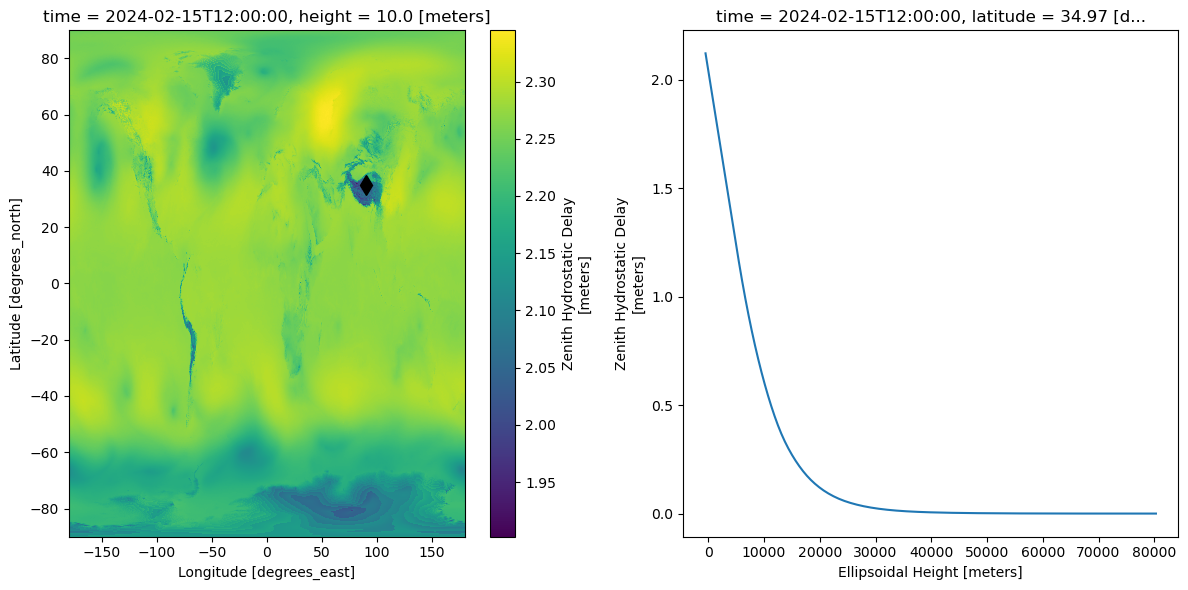

In [35]:
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(12,6))
ds.hydrostatic_delay.isel(time=0, height=8).plot.imshow(ax=ax[0])
ax[0].plot(90, 35, 'kd', ms=10)
ds.hydrostatic_delay.isel(time=0).sel(longitude=90, latitude=35, method='nearest').plot(ax=ax[1])
plt.tight_layout()

In [51]:
mask = (ds.height > 30e3).data
point = ds.hydrostatic_delay.isel(time=0).sel(longitude=90, latitude=35, method='nearest')
point[~mask].sum().values ,point[mask].sum().values

(array(114.14972, dtype=float32), array(0.16534434, dtype=float32))

In [52]:
mask = (ds.height > 35e3).data
point = ds.hydrostatic_delay.isel(time=0).sel(longitude=90, latitude=35, method='nearest')
point[~mask].sum().values ,point[mask].sum().values

(array(114.250336, dtype=float32), array(0.06472599, dtype=float32))